In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import utils

In [2]:
batch = '2024_01_23_Batch_7'
pipeline = 'profiles_tcdropped_filtered_var_mad_outlier_featselect'

In [3]:
type_col = 'Metadata_node_type'
gene_col = 'Metadata_symbol'
var_col = 'Metadata_gene_allele'

In [12]:
data_dir = f"../6.downstream_analysis_snakmake/outputs/batch_profiles/{batch}"
result_dir = f"../6.downstream_analysis_snakmake/outputs/results/{batch}/{pipeline}"
sc_profiles_path = f"{data_dir}/{pipeline}.parquet"
ppi_path = '../abundance_ppi_his3_edgotyping.tsv'

In [5]:
sc_profiles = pd.read_parquet(sc_profiles_path)
print(sc_profiles.shape)

(1862136, 1543)


In [6]:
sc_profiles['Cell_ID'] = sc_profiles.index
cell_count_df = sc_profiles.groupby(
    ['Metadata_Plate', 'Metadata_Well', 'Metadata_gene_allele']
)['Cell_ID'].count().reset_index()

In [59]:
df_ppi = pd.read_csv(ppi_path, sep='\t', header=0)
df_result = pd.read_csv(f'{result_dir}/result.csv')
df_threshold = pd.read_csv("outputs/data/thresholds.csv")

In [60]:
df_result['Group2'] = df_result['Group2'].apply(lambda x: x.split('_')[-1])

In [61]:
protein_thresh = df_threshold[df_threshold['Batch_ID']==batch]['score_thresh_protein'].item()
non_protein_thresh = df_threshold[df_threshold['Batch_ID']==batch]['score_thresh_protein'].item()

In [62]:
score_col = 'PR_AUC'
df_protein_ctrl, df_protein_var, df_non_protein_ctrl, df_non_protein_var = utils.split_result_dataframes(
    df_result, score_col=score_col)
df_protein_ctrl, df_protein_var, df_non_protein_ctrl, df_non_protein_var = utils.take_median(
    df_protein_ctrl, df_protein_var, df_non_protein_ctrl, df_non_protein_var
)

Dropped 10 NaN rows for PR_AUC column.


In [63]:
def map_clin_var(annot: str):
    if annot in ['Conflicting', 'not provided', np.nan, 'other']:
        return 'VUS'
    else:
        return annot

In [64]:
# Merge with ClinVar Annotation
df_protein_var = df_protein_var.merge(
    df_ppi[['symbol', 'aa_change', 'clinical_significance', 'z_abundance_change']], 
    how='left', 
    left_on=['Group1', 'Group2'],
    right_on=['symbol', 'aa_change'],
    )
df_non_protein_var = df_non_protein_var.merge(
    df_ppi[['symbol', 'aa_change', 'clinical_significance', 'z_abundance_change']], 
    how='left', 
    left_on=['Group1', 'Group2'],
    right_on=['symbol', 'aa_change'],
    )

In [65]:
df_protein_var['clinical_significance'] = df_protein_var['clinical_significance'].apply(lambda x: map_clin_var(x))
df_non_protein_var['clinical_significance'] = df_non_protein_var['clinical_significance'].apply(lambda x: map_clin_var(x))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

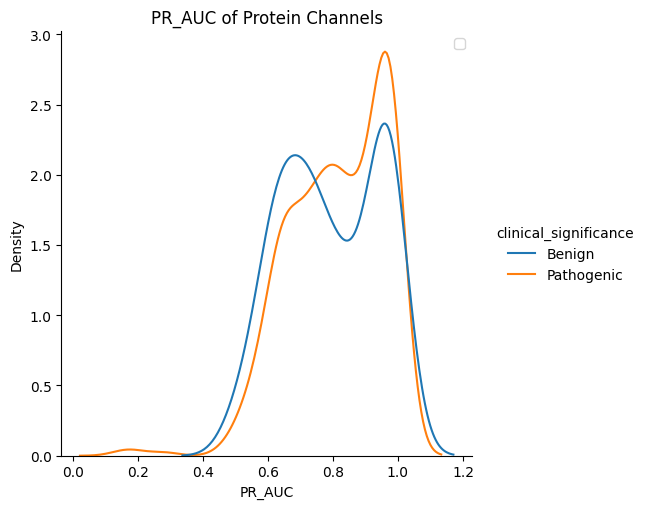

In [66]:
df_clinvar_pro = df_protein_var[df_protein_var['clinical_significance'].isin(['Benign', 'Pathogenic'])]
plt.figure()
metric = "PR_AUC"
sb.displot(
    df_clinvar_pro,
    x=metric,
    hue="clinical_significance",
    kind="kde",
    common_norm=False
)
plt.legend(loc=0)

plt.title(f"{metric} of Protein Channels")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

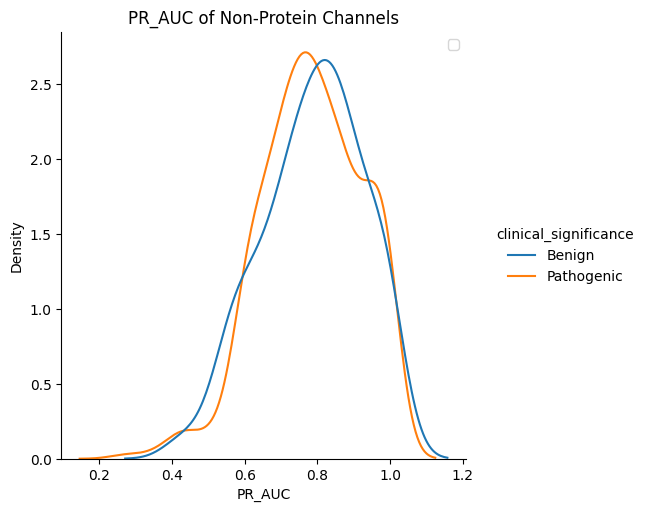

In [67]:
df_clinvar_nopro = df_non_protein_var[df_non_protein_var['clinical_significance'].isin(['Benign', 'Pathogenic'])]
plt.figure()
metric = "PR_AUC"
sb.displot(
    df_clinvar_nopro,
    x=metric,
    hue="clinical_significance",
    kind="kde",
    common_norm=False
)
plt.legend(loc=0)

plt.title(f"{metric} of Non-Protein Channels")
plt.show()

In [120]:
patho = df_protein_var[df_protein_var['clinical_significance']=='Pathogenic'].reset_index(drop=True)
patho['Passed'] = patho['PR_AUC'].apply(lambda x: 'Hit' if x>protein_thresh else 'Not hit')
patho_count = patho.groupby('Passed')['Group1'].count().reset_index()

benign = df_protein_var[df_protein_var['clinical_significance']=='Benign'].reset_index(drop=True)
benign['Passed'] = benign['PR_AUC'].apply(lambda x: 'Hit' if x>protein_thresh else 'Not hit')
benign_count = benign.groupby('Passed')['Group1'].count().reset_index()

vus = df_protein_var[df_protein_var['clinical_significance']=='VUS'].reset_index(drop=True)
vus['Passed'] = vus['PR_AUC'].apply(lambda x: 'Hit' if x>protein_thresh else 'Not hit')
vus_count = vus.groupby('Passed')['Group1'].count().reset_index()

Text(0.5, 1.0, 'Pathogenic variants passing classfication test')

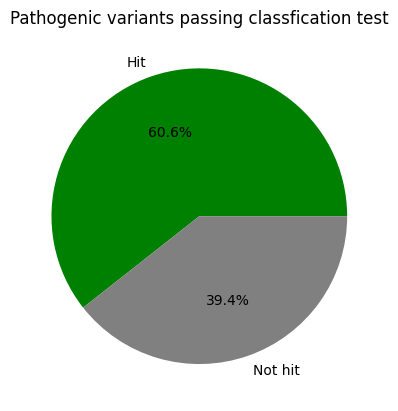

In [123]:
cmap_dict = ['green', 'gray']
fig, ax = plt.subplots()
ax.pie(patho_count['Group1'], labels=patho_count['Passed'], colors=cmap_dict, autopct='%1.1f%%')
plt.title('Pathogenic variants passing classfication test')

Text(0.5, 1.0, 'Benign variants passing classfication test')

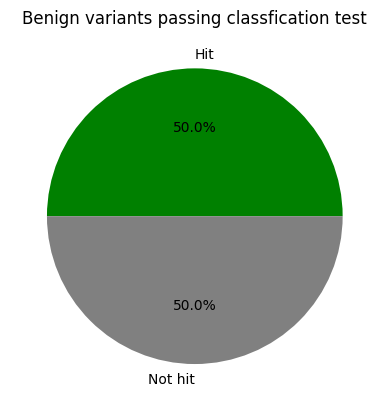

In [124]:
fig, ax = plt.subplots()
ax.pie(benign_count['Group1'], labels=benign_count['Passed'], colors=cmap_dict, autopct='%1.1f%%')
plt.title('Benign variants passing classfication test')

Text(0.5, 1.0, 'VUS variants passing classfication test')

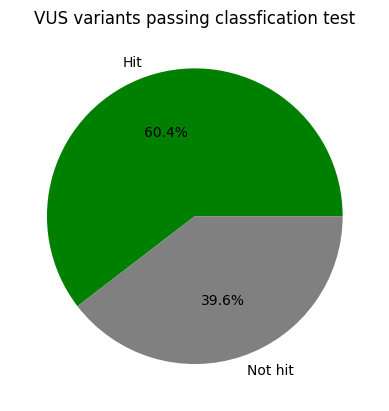

In [125]:
fig, ax = plt.subplots()
ax.pie(vus_count['Group1'], labels=vus_count['Passed'], colors=cmap_dict, autopct='%1.1f%%')
plt.title('VUS variants passing classfication test')

In [133]:
benign[benign['Passed']=='Hit'].sort_values('PR_AUC').reset_index()

,index,Group1,Group2,PR_AUC,Metadata_Control,symbol,aa_change,clinical_significance,z_abundance_change,Passed
0,68,MCEE,Arg143His,0.776904,False,MCEE,Arg143His,Benign,-1.558617,Hit
1,26,CTH,Ser403Ile,0.802382,False,CTH,Ser403Ile,Benign,NaN,Hit
2,22,COMP,Ala171Thr,0.811242,False,COMP,Ala171Thr,Benign,-1.320209,Hit
3,87,PITX1,Gly299Ala,0.815930,False,PITX1,Gly299Ala,Benign,NaN,Hit
4,0,ACSF3,Ala17Pro,0.817713,False,ACSF3,Ala17Pro,Benign,-0.909366,Hit
...,...,...,...,...,...,...,...,...,...,...
57,21,CLDN19,Arg200Gln,0.996778,False,CLDN19,Arg200Gln,Benign,0.016760,Hit
58,32,EFHC1,Arg159Trp,0.997406,False,EFHC1,Arg159Trp,Benign,-0.163761,Hit
59,41,GFAP,Asp295Asn,0.997725,False,GFAP,Asp295Asn,Benign,-1.549525,Hit
60,49,IL2RG,Glu109Lys,0.999495,False,IL2RG,Glu109Lys,Benign,NaN,Hit
